# PROYECTO FINAL - BEHAVIORAL CLONNING

## Integrantes del equipo N° #16:

A00572928 - André Martins Cordebello

A01334976 - Israel Campos Báez

A01166758 - Juan Manuel Carballo Montaño

A01795149 - Kevin Balderas Sánchez

A01793650 - Jessica Paola Pulido Vásquez


## Docentes:

Dr. David Antonio Torres

Dr. Luis Anselmo Fortoul Díaz



**Maestría en Inteligencia Artificial Aplicada**

**MR4010 - Navegación Autónoma**


Fecha: 23 de Junio de 2024

## Cargamos dependencias a utilizar

In [36]:
import cv2
import os
import random
import matplotlib.image as mpimg
from imgaug import augmenters as iaa
import tensorflow as tf
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.utils import shuffle
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten , Input

## Preprocesamiento de datos

In [47]:
data = pd.read_csv('./Golden_Dataset/Golden_Dataset/steering_angles.csv')

In [48]:
data.head()

,image_path,steering_angle
0,Training/0.png,0.0
1,Training/1.png,0.0
2,Training/2.png,0.0
3,Training/3.png,0.0
4,Training/4.png,0.0


In [49]:
data.shape

(61160, 2)

In [50]:
data.columns = ['image_path','steeringAngle']

## Examinamos balanceo de clases y proponemos un límite para no tener muchos valores con valor 0

total data: 61160


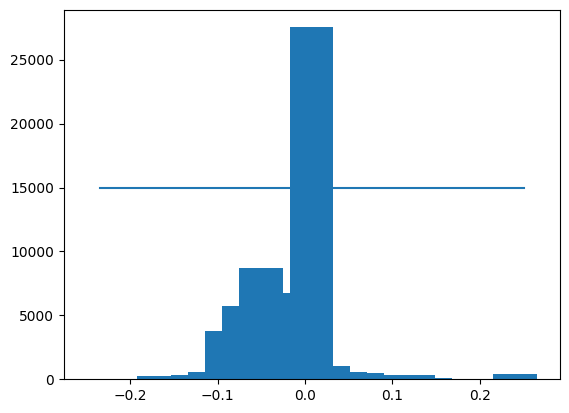

In [51]:
num_bins = 25
samples_per_bin = 15000
hist, bins = np.histogram(data["steeringAngle"], num_bins)
center = (bins[:-1] + bins[1:]) *0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steeringAngle']), np.max(data['steeringAngle'])), (samples_per_bin, samples_per_bin))
print('total data:', len(data))
plt.show()

removed: 12533
remaining: 48627


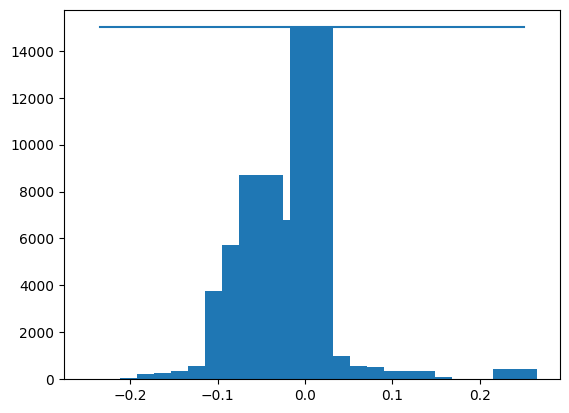

In [52]:
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steeringAngle'])):
        if data['steeringAngle'][i] >= bins[j] and data['steeringAngle'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steeringAngle'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steeringAngle']), np.max(data['steeringAngle'])), (samples_per_bin, samples_per_bin))
plt.show()

In [53]:
print(data.iloc[1])

image_path       Training/1.png
steeringAngle               0.0
Name: 1, dtype: object


## Guardamos imagen y valor de steering

In [58]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center= indexed_data[0] #Training/0.png
        center = center.split('/')[-1]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[1]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings

image_paths, steerings = load_img_steering('./Golden_Dataset/Golden_Dataset/Training/', data)

C:\Users\balde\AppData\Local\Temp\ipykernel_13648\776632153.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  center= indexed_data[0] #Training/0.png
C:\Users\balde\AppData\Local\Temp\ipykernel_13648\776632153.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  steering.append(float(indexed_data[1]))


In [59]:
image_paths[0]

'./Golden_Dataset/Golden_Dataset/Training/0.png'

In [60]:
steerings[0]

0.0

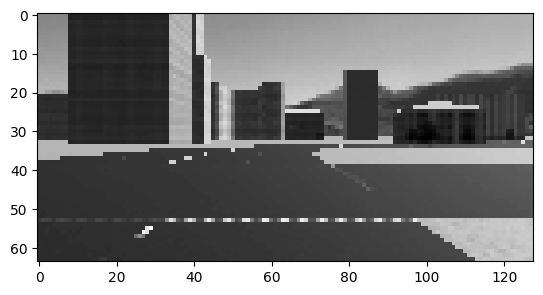

In [65]:
original_image = mpimg.imread(image_paths[0])
plt.imshow(original_image, cmap='gray')
plt.show()

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=42)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)))

Training Samples: 38901
Valid Samples: 9726


## Vemos la distribución tanto en training y validation

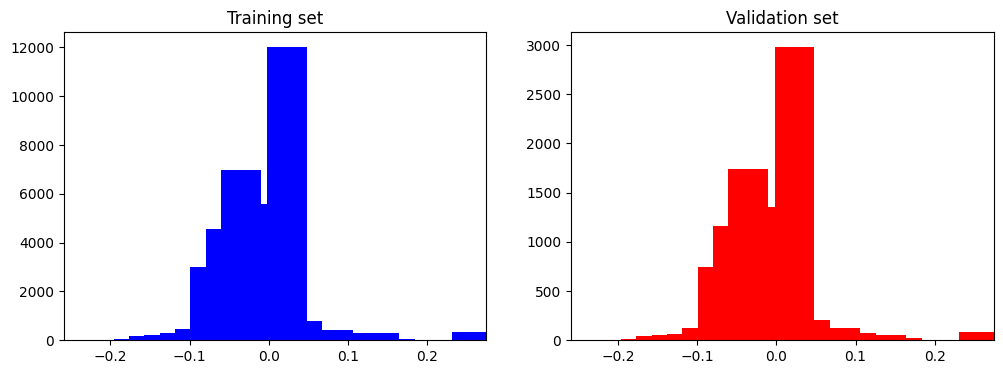

In [63]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')
plt.show()

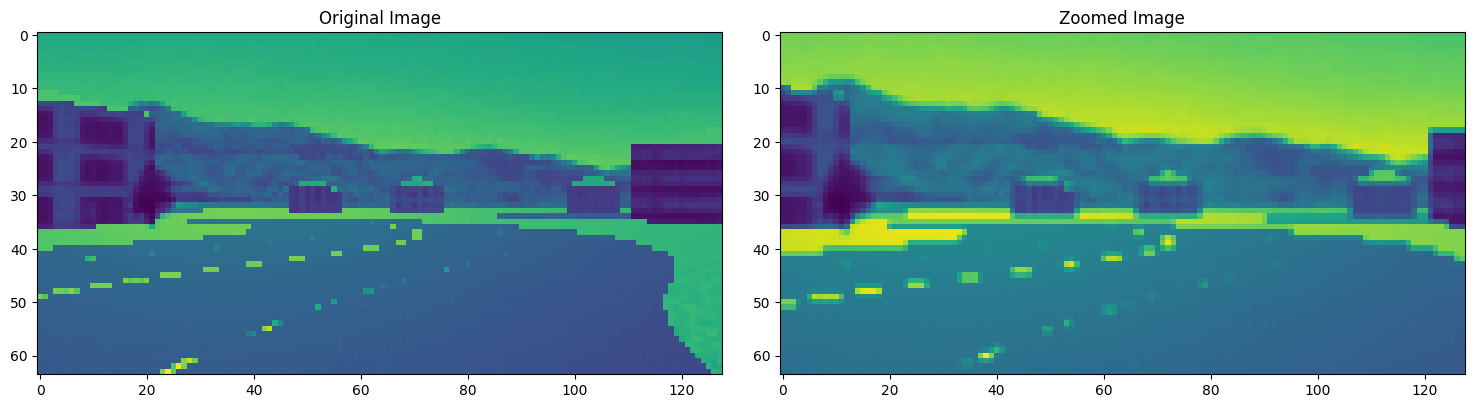

In [66]:
#Función para hacer zoom en imagen
def zoom(image):
    zoom = iaa.Affine(scale=(1, 1.3))
    image = zoom.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

#Subplots para hacer comparación de imagen original y procesada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed Image')
plt.show()

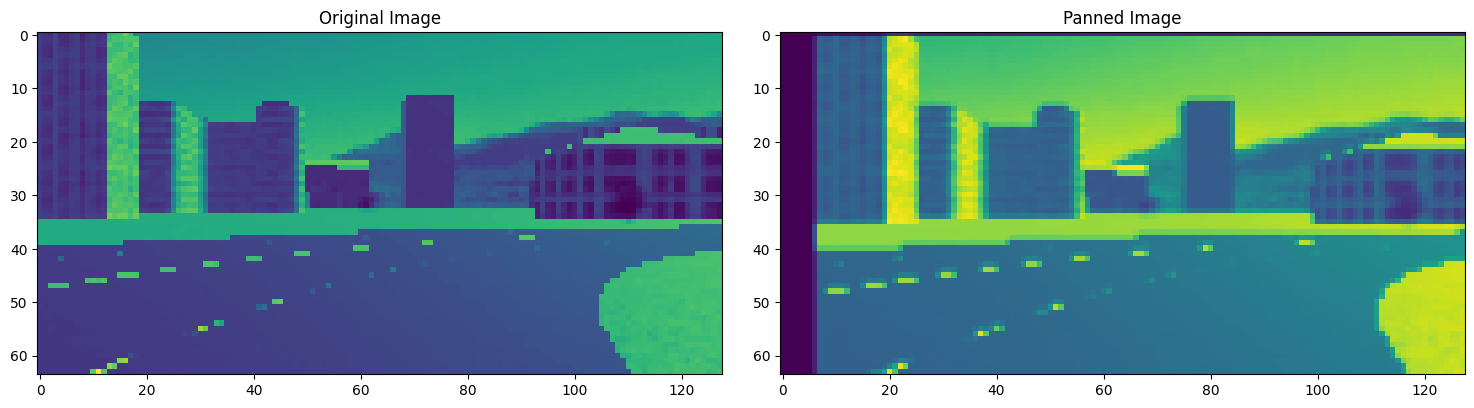

In [67]:
#Función para seleccionar zona de la imagen
def pan(image):
    pan = iaa.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image


image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

#Subplots para hacer comparación de imagen original y procesada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(panned_image)
axs[1].set_title('Panned Image')
plt.show()

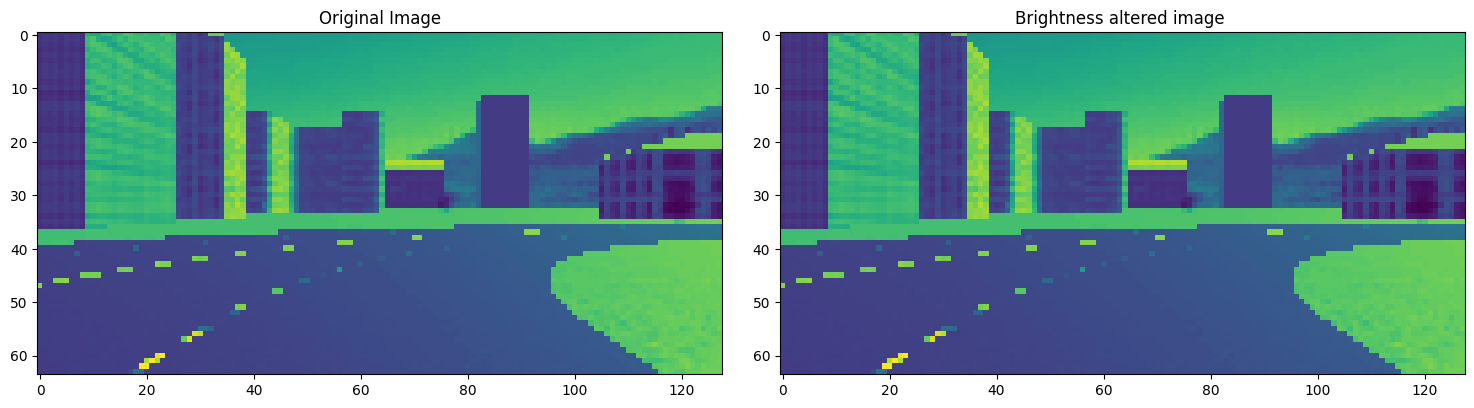

In [68]:
# Función para modificar intensidad de imagen
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)


#Subplots para hacer comparación de imagen original y procesada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image')

axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image ')
plt.show()

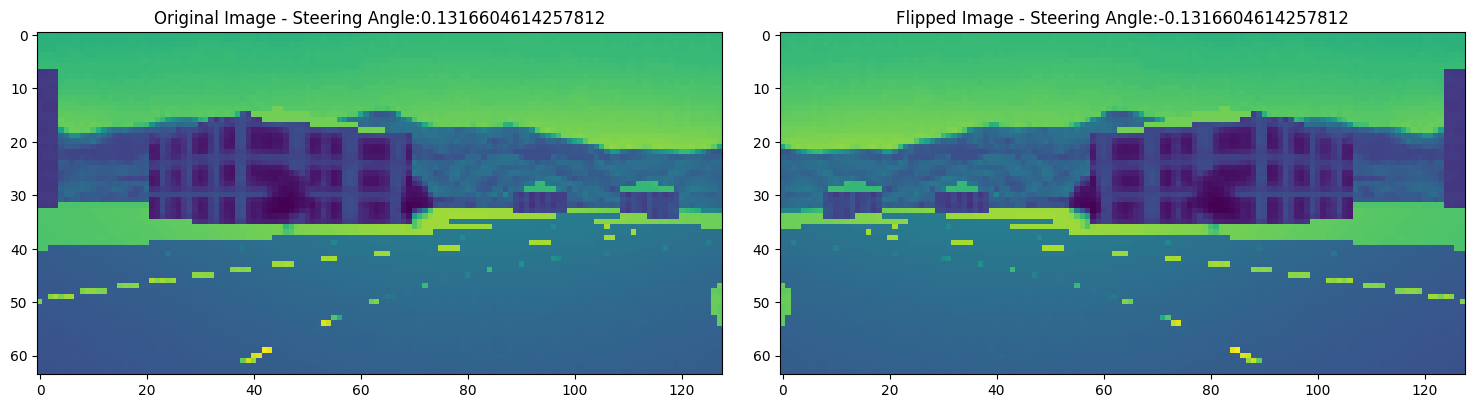

In [69]:
#Función para hacer un efecto espejo de la imagen
def img_random_flip(image, steering_angle):
    image = cv2.flip(image,1)
    steering_angle = -steering_angle
    return image, steering_angle


random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]


original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

#Subplots para hacer comparación de imagen original y procesada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(original_image)
axs[0].set_title('Original Image - ' + 'Steering Angle:' + str(steering_angle))

axs[1].imshow(flipped_image)
axs[1].set_title('Flipped Image - ' + 'Steering Angle:' + str(flipped_steering_angle))
plt.show()

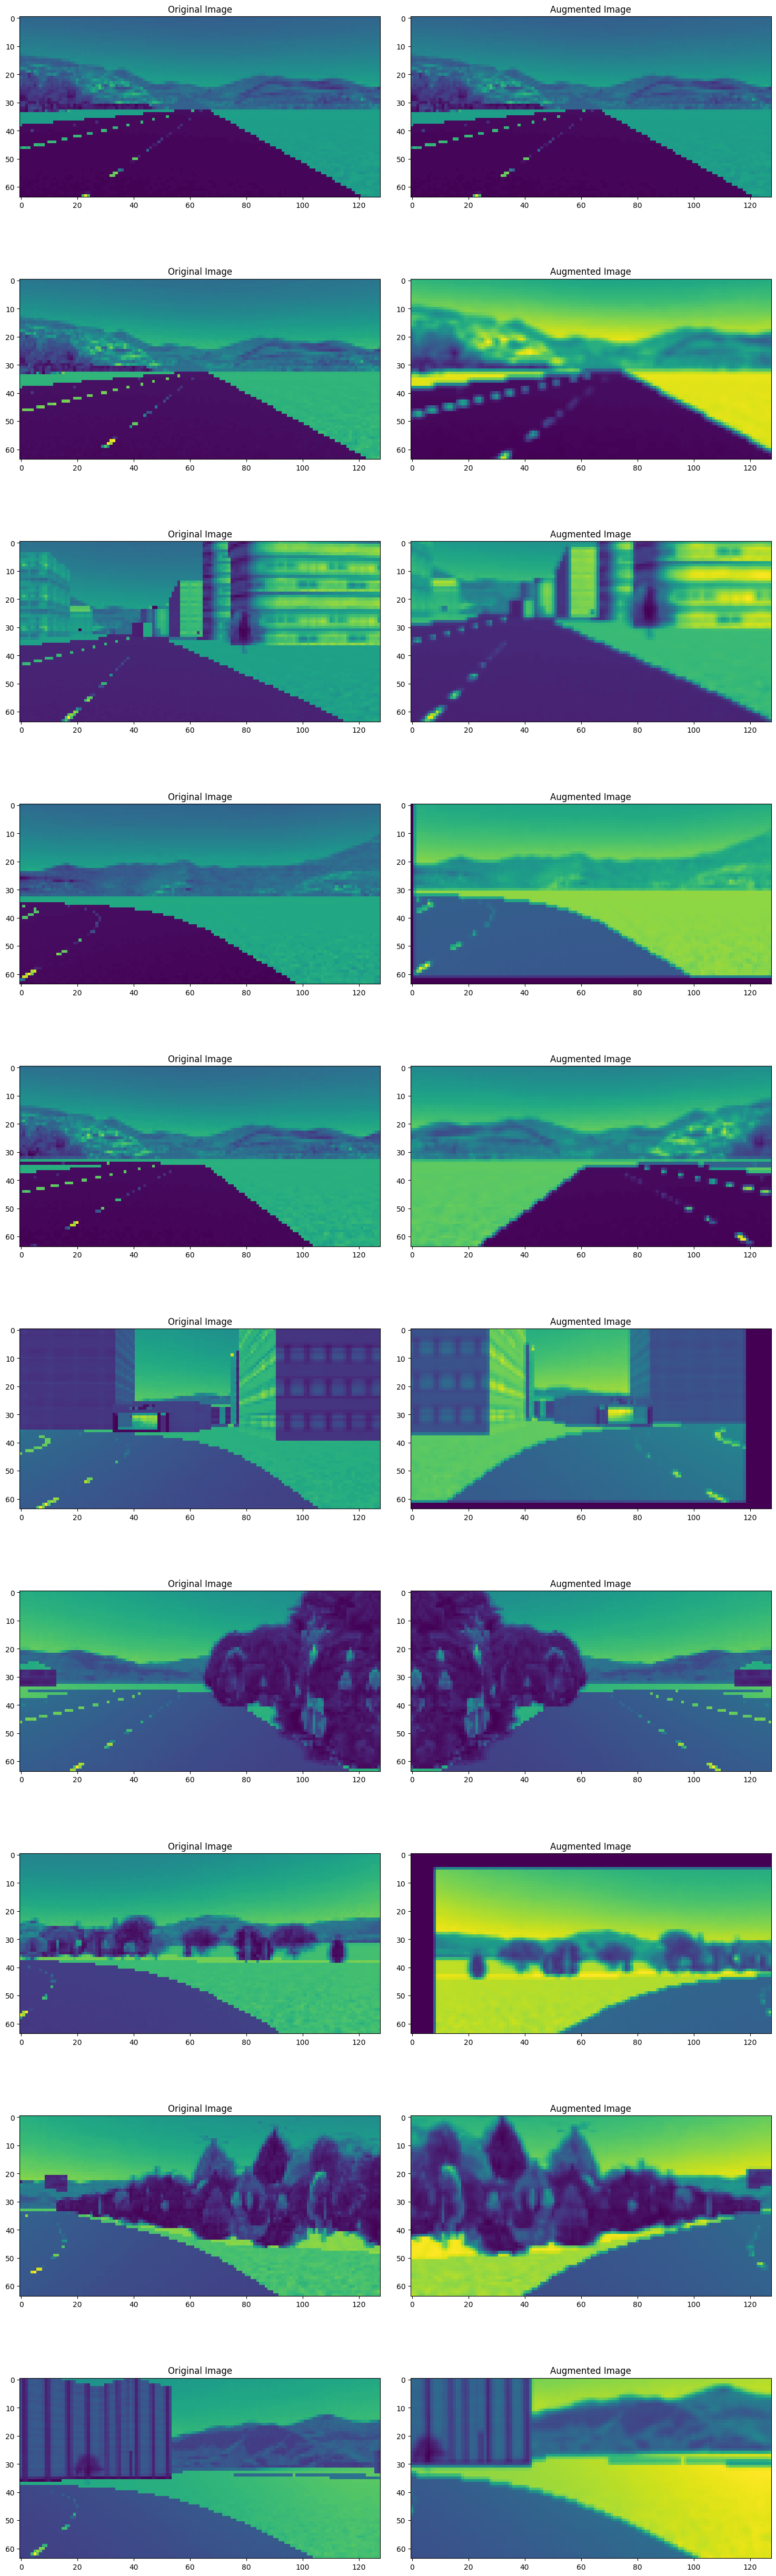

In [70]:
#Función que combina diferentes efectos de las funciones pasadas
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)

    return image, steering_angle


ncol = 2
nrow = 10

#Subplots para hacer comparación de imagen original y procesada
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

for i in range(10):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]

    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)

    axs[i][0].imshow(original_image)
    axs[i][0].set_title("Original Image")

    axs[i][1].imshow(augmented_image)
    axs[i][1].set_title("Augmented Image")

(64, 128)


Text(0.5, 1.0, 'Preprocessed Image')

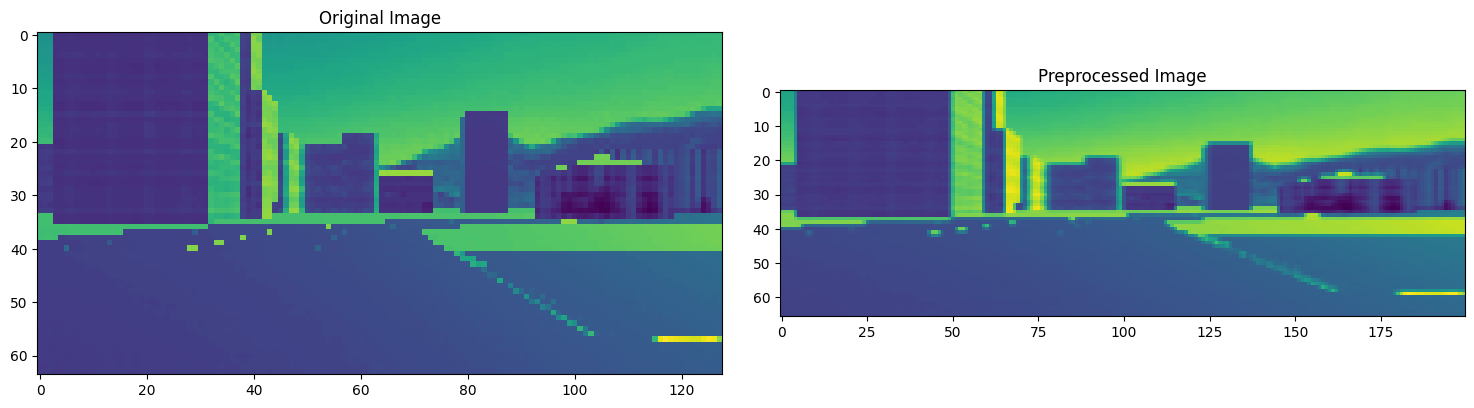

In [76]:
#Función para preprocesar iamgen y realizar un escalamiento de valores. 
def img_preprocess(img):
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

image = image_paths[100]
original_image = mpimg.imread(image)
print(original_image.shape)
preprocessed_image = img_preprocess(original_image)

#Subplots para hacer comparación de imagen original y procesada
fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original Image')
axs[1].imshow(preprocessed_image)
axs[1].set_title('Preprocessed Image')

In [77]:
#Función que realiza el batch de imagenes para hacer entrenamiento y validación
def batch_generator(image_paths, steering_ang, batch_size, istraining):

    while True:
        batch_img = []
        batch_steering = []

        for i in range(batch_size):
            
            random_index = random.randint(0, len(image_paths) - 1)
           
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        yield (np.asarray(batch_img), np.asarray(batch_steering))

Text(0.5, 1.0, 'Validation Image')

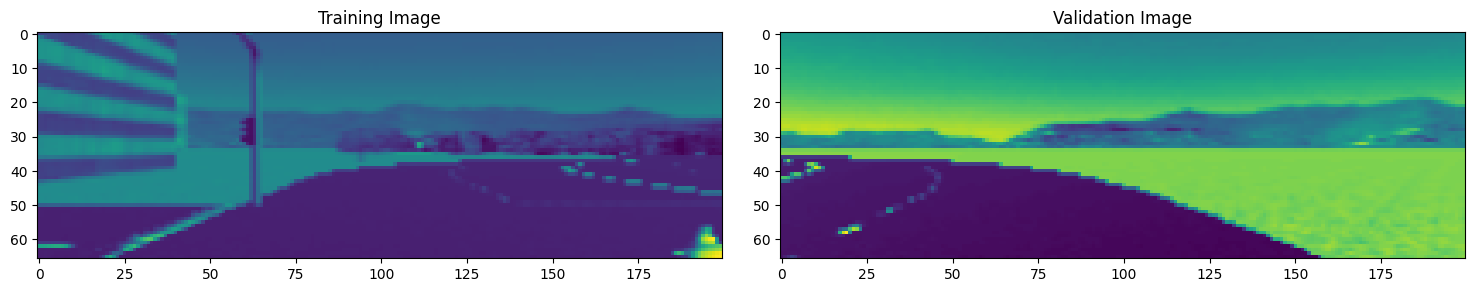

In [78]:
#Observamos ejemplos de imagenes de entrenamiento y validación
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()

axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training Image')

axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation Image')

## Entrenamiento

In [79]:
#Modelo de red neuronal para navegación autónoma
def nvidia_model():
    #Tipo secuencial
    model = tf.keras.Sequential()
    #Input shape con el formato de imagen propuesto de 66x200
    model.add(tf.keras.layers.Input(shape=(66, 200, 1)))
    #Bloque de 5 convoluciones
    model.add(tf.keras.layers.Convolution2D(24, kernel_size=(5,5),strides=(2,2),activation='elu'))
    model.add(tf.keras.layers.Convolution2D(36, kernel_size=(5,5),strides=(2,2),activation='elu'))
    model.add(tf.keras.layers.Convolution2D(48, kernel_size=(5,5),strides=(2,2),activation='elu'))
    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3,3),activation='elu'))

    # model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3,3),activation='elu'))

    #Bloque flatten para aplanar unidades anteriores
    model.add(tf.keras.layers.Flatten())
    #Bloque de tipo denso para ir conectando unidades finales
    model.add(tf.keras.layers.Dense(100, activation = 'elu'))
    
    model.add(tf.keras.layers.Dense(50, activation = 'elu'))
    

    model.add(tf.keras.layers.Dense(10, activation = 'elu'))
    
    #Última unidad de entrenamiento para predecir valor de steering angle
    model.add(tf.keras.layers.Dense(1))

    #Función de permida para un problema de regresión
    optimizer = Adam(learning_rate=1e-3)
    model.compile(loss='mse', optimizer=optimizer)
    return model

In [91]:
#Segundo modelo propuesto para experimentar. En general, se obtuvo mejores resultados con el primer modelo
def nvidia_model2():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(66, 200, 1)))
    model.add(tf.keras.layers.Convolution2D(42, kernel_size=(5,5),strides=(2,2),activation='elu'))
    model.add(tf.keras.layers.Convolution2D(16, kernel_size=(5,5),strides=(2,2),activation='elu'))

    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.Convolution2D(64, kernel_size=(3,3),activation='elu'))

    model.add(tf.keras.layers.Flatten())
    
    model.add(tf.keras.layers.Dense(50, activation = 'tanh'))    

    model.add(tf.keras.layers.Dense(1))

    optimizer = Adam(learning_rate=0.01)
    model.compile(loss='mse', optimizer=optimizer, metrics=['acc'])
    return model

In [80]:
model2 = nvidia_model() #Mandamos a llamar al modelo

In [81]:
print(model2.summary()) #Vemos el numero de parametros

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 31, 98, 24)          │             624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 14, 47, 36)          │          21,636 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 5, 22, 48)           │          43,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 3, 20, 64)           │          27,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 18, 64)           │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1152)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │         115,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 50)                  │           5,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │             510 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              11 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,019 (980.54 KB)

 Trainable params: 251,019 (980.54 KB)

 Non-trainable params: 0 (0.00 B)

None


In [82]:
#Función para llevar a cabo el entrenamiento , 10 epocas
history = model2.fit(batch_generator(X_train, y_train, 100, 1),
                              steps_per_epoch=300,
                              epochs=10,
                              validation_data=batch_generator(X_valid, y_valid, 100, 0),
                              validation_steps=300,
                              verbose=1,
                              shuffle = 1)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 182s 589ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 160s 535ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 154s 515ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 155s 520ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 157s 525ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 158s 528ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 160s 533ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 133s 443ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 106s 354ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 135s 452ms/step - loss: 0.0016 - val_loss: 0.0012


Text(0.5, 0, 'Epoch')

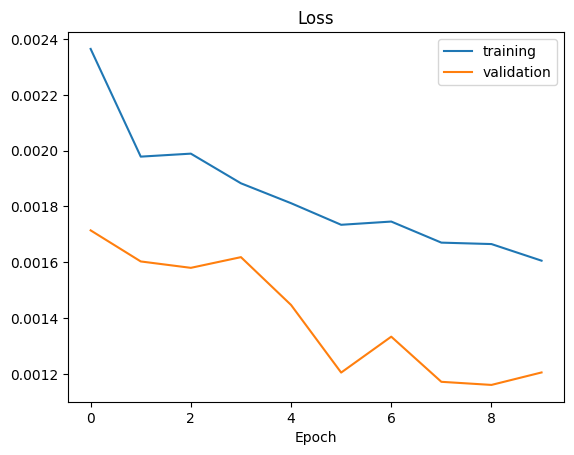

In [84]:
#Imprimos graficas de perdida
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [85]:
model2.save('model3.h5') #Salvamos modelo con formato h5

In [86]:
model2.save('model3.keras')#Salvamos modelo con formato keras

## Predicción

Text(0.5, 1.0, 'Original Image - Steering Angle:-0.0723342895507812')

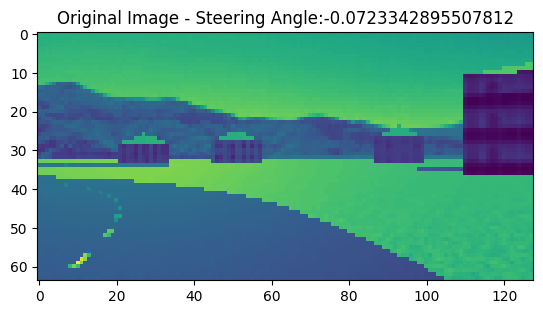

In [99]:
#Tomamos indice cualquiera para empezar la predicción
random_index = 1000
image = mpimg.imread(image_paths[random_index])
steering = steerings[random_index]

im2 = img_preprocess(image)
plt.imshow(image)
plt.title('Original Image - ' + 'Steering Angle:' + str(steering))

In [100]:
#Necesario agregar una última dimensión tanto para predecir como para webots
test_img = np.expand_dims(im2,axis=0)
test_img.shape

(1, 66, 200)

In [101]:
# Realizar la predicción
model2.predict(test_img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step


array([[-0.06655287]], dtype=float32)

# Controlador en Webots

In [ ]:
import os
import cv2

import tensorflow as tf
import numpy as np

from vehicle import Car, Driver
from controller import Display, Keyboard, Robot, Camera

def init_camera(camera: Camera, timestep: int):
    camera.enable(timestep)


def limit(value, max = 1, min = -1):
    if value < min:
        return min
    elif value > max:
        return max
    else:
        return round(value, 4)


def get_image(camera: Camera):
    raw_image = camera.getImage()
    image = np.frombuffer(raw_image, np.uint8).reshape(
        (camera.getHeight(), camera.getWidth(), 4)
    )
    return image[:, :, :3]


def img_preprocess(img):
    img = np.copy(img)
    img[0:85,:,:] = 0
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img



def main():
    # Inicializar instancias
    vehicle = Car()
    timestep = int(vehicle.getBasicTimeStep())
    front_camera = vehicle.getDevice("front_camera")
    
    init_camera(front_camera, timestep)    
    
    model = tf.keras.models.load_model("./model3.keras")
        
    while vehicle.step() != -1:
        image = get_image(front_camera)
        image = img_preprocess(image)
        steering_angle = model.predict(image.reshape(1, 66, 200, 1), verbose=0)
        steering_angle = limit(steering_angle[0][0], min=-0.065, max=0.065)
        
        print(steering_angle)
        vehicle.setSteeringAngle(steering_angle)
        vehicle.setCruisingSpeed(25)


if __name__ == "__main__":
    try:
        main()
    except Exception as e:
        print(e.with_traceback())
        exit(0)

# Link video youtube

https://www.youtube.com/watch?v=1kt-i_b97FY